# 非线性支持向量机

### 定义 非线性支持向量机

从非线性分类训练集，通过核函数与软间隔最大化，或凸二次规划，学习得到的分类决策函数
$${f(x)=\operatorname{sign}\left(\sum_{i=1}^{N} \alpha_{i}^{*} y_{i} K\left(x, x_{i}\right)+b^{*}\right)}$$
这个分类决策函数称为非线性支持向量机，$K(x,z)$是正定核函数

### 算法 非线性支持向量机学习算法

输入：训练集$T=\{(x_1,y_1),(x_2,y_2),...,(x_N,y_N)\}$,其中$\mathcal{X}=\mathcal{R}^{n},y_i \in \mathcal{Y}=\{-1,+1\},i=1,2,...,N$;

输出：分类决策函数

第一步：选取适当的核函数$K(x,z)$和适当的参数$C$,构造并求解最优化问题：
$$\min _{\alpha} \frac{1}{2} \sum_{i=1}^{N} \sum_{j=1}^{N} \alpha_{i} \alpha_{j} y_{i} y_{j} K\left(x_{i} \cdot x_{j}\right)-\sum_{i=1}^{N} \alpha_{i}$$

$$s.t. \quad \sum_{i=1}^{N} \alpha_{i} y_{i}=0$$

$$0 \leqslant \alpha_{i} \leqslant C, \quad i=1,2, \cdots, N$$

求得最优化问题的解$\alpha^{*}=(\alpha_{1}^{*},\alpha_{2}^{*}, \cdots,\alpha_{N}^{*})^{T}$

第二步：选择$\alpha^{*}$的一个正分量$0< \alpha_{j}^{*}<C$,计算
$$b^{*}=y_i-\sum_{i=1}^{N}\alpha_{i}^{*}y_i K(x_i,x_j)$$


第三步：构造决策函数
$$f(x)=\operatorname{sign}\left(\sum_{i=1}^{N} \alpha_{i}^{*}y_i K(x_i,x_j)\right)$$

**注：当$K(x,z)$是正定函数时，(1)、(2)、(3)是凸二次规划问题，存在解。**

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn import datasets
from tensorflow.python.framework import ops
ops.reset_default_graph()

sess = tf.Session()

E:\softinstall\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
E:\softinstall\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
E:\softinstall\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
E:\softinstall\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:529: FutureWarning: Passi

加载数据

In [2]:
# iris.数据 [(Sepal Length, Sepal Width, Petal Length, Petal Width)]
iris = datasets.load_iris()
x_vals = np.array([[x[0], x[3]] for x in iris.data])
y_vals = np.array([1 if y==0 else -1 for y in iris.target])
class1_x = [x[0] for i,x in enumerate(x_vals) if y_vals[i]==1]
class1_y = [x[1] for i,x in enumerate(x_vals) if y_vals[i]==1]
class2_x = [x[0] for i,x in enumerate(x_vals) if y_vals[i]==-1]
class2_y = [x[1] for i,x in enumerate(x_vals) if y_vals[i]==-1]

声明模型变量

In [3]:
# 批量大小
batch_size = 150

# 初始化占位符
x_data = tf.placeholder(shape=[None, 2], dtype=tf.float32)
y_target = tf.placeholder(shape=[None, 1], dtype=tf.float32)
prediction_grid = tf.placeholder(shape=[None, 2], dtype=tf.float32)

# 创建变量
b = tf.Variable(tf.random_normal(shape=[1,batch_size]))

Instructions for updating:
Colocations handled automatically by placer.


本案例采用高斯核函数，将低维空间数据转换为高维空间数据
$$K(x, x')=exp\left(-\gamma|| x-x' ||^{2}\right)$$

损失函数：
$$-\left(\sum\textbf{b} - \sum\left(K\cdot||\textbf{b}||^{2}||\textbf{y}||^{2}\right)\right)$$

In [4]:
# 高斯核函数 (RBF) 
gamma = tf.constant(-50.0)
sq_vec = tf.multiply(2., tf.matmul(x_data, tf.transpose(x_data)))
my_kernel = tf.exp(tf.multiply(gamma, tf.abs(sq_vec)))

In [5]:
# SVM模型的损失函数
first_term = tf.reduce_sum(b)
b_vec_cross = tf.matmul(tf.transpose(b), b)
y_target_cross = tf.matmul(y_target, tf.transpose(y_target))
second_term = tf.reduce_sum(tf.multiply(my_kernel, tf.multiply(b_vec_cross, y_target_cross)))
loss = tf.negative(tf.subtract(first_term, second_term))

声明预测时所采用的的核函数 RBF

In [6]:
rA = tf.reshape(tf.reduce_sum(tf.square(x_data), 1),[-1,1])
rB = tf.reshape(tf.reduce_sum(tf.square(prediction_grid), 1),[-1,1])
pred_sq_dist = tf.add(tf.subtract(rA, tf.multiply(2., tf.matmul(x_data, tf.transpose(prediction_grid)))), tf.transpose(rB))
pred_kernel = tf.exp(tf.multiply(gamma, tf.abs(pred_sq_dist)))

prediction_output = tf.matmul(tf.multiply(tf.transpose(y_target),b), pred_kernel)
prediction = tf.sign(prediction_output-tf.reduce_mean(prediction_output))
accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.squeeze(prediction), tf.squeeze(y_target)), tf.float32))

In [7]:
# 优化器的设置
my_opt = tf.train.GradientDescentOptimizer(0.01)
train_step = my_opt.minimize(loss)

# 初始化变量
init = tf.global_variables_initializer()
sess.run(init)

In [8]:
# 开始训练
loss_vec = []
batch_accuracy = []
for i in range(300):
    rand_index = np.random.choice(len(x_vals), size=batch_size)
    rand_x = x_vals[rand_index]
    rand_y = np.transpose([y_vals[rand_index]])
    sess.run(train_step, feed_dict={x_data: rand_x, y_target: rand_y})
    
    temp_loss = sess.run(loss, feed_dict={x_data: rand_x, y_target: rand_y})
    loss_vec.append(temp_loss)
    
    acc_temp = sess.run(accuracy, feed_dict={x_data: rand_x,
                                             y_target: rand_y,
                                             prediction_grid:rand_x})
    batch_accuracy.append(acc_temp)
    
    if (i+1)%75==0:
        print('Step #' + str(i+1))
        print('Loss = ' + str(temp_loss))

Step #75
Loss = -97.21663
Step #150
Loss = -209.71655
Step #225
Loss = -322.21643
Step #300
Loss = -434.7165


In [9]:
# Create a mesh to plot points in
x_min, x_max = x_vals[:, 0].min() - 1, x_vals[:, 0].max() + 1
y_min, y_max = x_vals[:, 1].min() - 1, x_vals[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                     np.arange(y_min, y_max, 0.02))
grid_points = np.c_[xx.ravel(), yy.ravel()]
[grid_predictions] = sess.run(prediction, feed_dict={x_data: x_vals,
                                                   y_target: np.transpose([y_vals]),
                                                   prediction_grid: grid_points})
grid_predictions = grid_predictions.reshape(xx.shape)

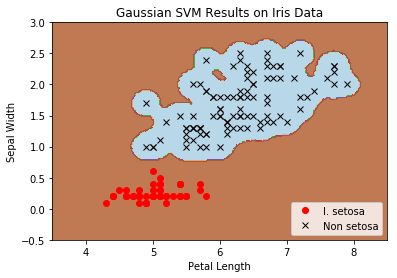

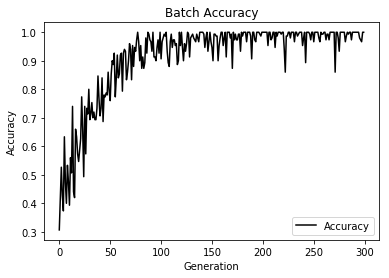

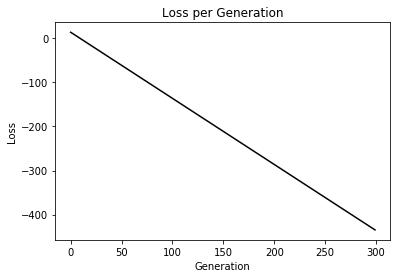

In [10]:
%matplotlib inline
# Plot points and grid
plt.contourf(xx, yy, grid_predictions, cmap=plt.cm.Paired, alpha=0.8)
plt.plot(class1_x, class1_y, 'ro', label='I. setosa')
plt.plot(class2_x, class2_y, 'kx', label='Non setosa')
plt.title('Gaussian SVM Results on Iris Data')
plt.xlabel('Petal Length')
plt.ylabel('Sepal Width')
plt.legend(loc='lower right')
plt.ylim([-0.5, 3.0])
plt.xlim([3.5, 8.5])
plt.show()

# Plot batch accuracy
plt.plot(batch_accuracy, 'k-', label='Accuracy')
plt.title('Batch Accuracy')
plt.xlabel('Generation')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

# Plot loss over time
plt.plot(loss_vec, 'k-')
plt.title('Loss per Generation')
plt.xlabel('Generation')
plt.ylabel('Loss')
plt.show()

**上述案例均已通过**

----
参考资料：  
《统计学习方法》  
《Tensorflow-machine-learning-cookbook》  

整理制作：深度学习学研社

<div>
<table align="left" border="1" bordercolor="#000000">
    <div>
    <tr>
        <td>
            微信公众号：ID: AI_class_vip<br>
            <img src="../image/gongzhonghao.jpg" width="150" height="150" align="left"/>    
        </td>
    </tr>
    </div>
    <div>
    <tr>
        <td>
        知识星球：机器学习交流学习圈：<br>
    <img src="../image/dlzhishixingqiu.jpg" width="150" height="150" align="left"/>  
        </td>
    </tr>
        </div>
    <div>
     <tr>
        <td>
        配置环境：python 3.4+  
        </td>
    </tr>
        </div>
</table>
</div>
